# Autoencoder from scratch

# Demo autoencoder

## Objective

In this notebook, we implement a demo for the autoencoder building process. The goal is to:

- Implement a basic pipeline that can be later used in the complete version with scripts.
- Visualize the data and key steps (inputs, reconstructions, errors).
- Define the architecture in a basic, modular way to allow experimentation.
- Assess training performance and plot evaluation results.

This version works on a **single object class** from the MVTec AD dataset (e.g., `metal_nut`) using **grayscale images resized to 64×64**, and a simple **autoencoder** implemented from scratch in NumPy.

## 1. Preprocessing the Data
In this first section, we define a prototype for the preprocessing pipeline.
Its purpose is to:

- Load images from a selected class (e.g., 'metal_nut') in the MVTec AD dataset.
- Convert them to grayscale for simplicity.
- Resize them to a fixed shape (64×64) to standardize input dimensions.
- Normalize pixel values to the [0, 1] range for stability in training.

This prototype will later be converted into a reusable script module for the full pipeline.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def load_images(folder_path, image_size=(64, 64), grayscale=True):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            path = os.path.join(folder_path, filename)
            img = cv2.imread(path)
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0 
            images.append(img)

    images = np.array(images)
    
    if grayscale:
        images = images[..., np.newaxis] 
    
    return images

path = '../data/metal_nut/train/good/'
X_train = load_images(path, image_size=(64, 64))

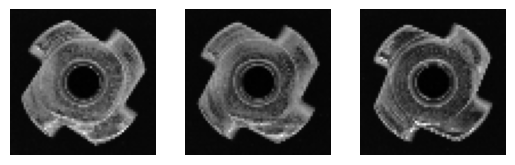

In [2]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(X_train[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## 2. Model definition

In [3]:
class ReLU_neuron:
    @staticmethod
    def function(x):
        return np.maximum(0, x)
    @staticmethod
    def der(x):
        return (x > 0).astype(float)    

class Autoencoder:
    def __init__(self, input_dim, hidden_dim_encoder, hidden_dim_decoder, H, W):
        self.weights_encoder = []
        self.biases_encoder = []
        self.weights_decoder = []
        self.biases_decoder = []
        self.H = H
        self.W = W
        
        prev_d = input_dim
        for dim in hidden_dim_encoder:
            w = np.random.randn(prev_d, dim) * 0.01
            b = np.zeros((1, dim))
            self.weights_encoder.append(w)
            self.biases_encoder.append(b)
            prev_d = dim
            
        for dim in hidden_dim_decoder:
            w = np.random.randn(prev_d, dim) * 0.01
            b = np.zeros((1, dim))
            self.weights_decoder.append(w)
            self.biases_decoder.append(b)
            prev_d = dim
            
    def encoder(self, image):
        z = image.reshape(1, -1)  
        for i in range(len(self.weights_encoder)):
            z = np.dot(z, self.weights_encoder[i]) + self.biases_encoder[i]
            z = ReLU_neuron.function(z)
        return z
    
    def decoder(self, z):
        for i in range(len(self.weights_decoder)):
            z = np.dot(z, self.weights_decoder[i]) + self.biases_decoder[i]
            if i < len(self.weights_decoder) - 1:
                z = ReLU_neuron.function(z)
            else:
                z = 1.0 / (1 + np.exp(-z)) 
        image = z.reshape(self.H, self.W)
        return image

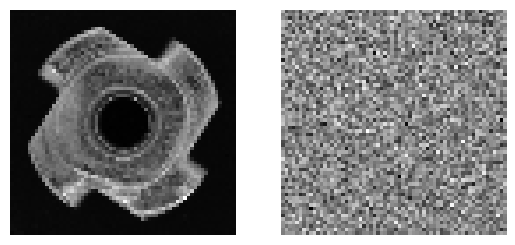

In [4]:
H, W = 64, 64
input_dim = H * W
ae = Autoencoder(input_dim, hidden_dim_encoder=[128, 64], hidden_dim_decoder=[128, input_dim], H=H, W=W)

img = np.random.rand(H, W, 4)
code = ae.encoder(X_train[0])
reconstructed = ae.decoder(code)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(reconstructed, cmap='gray')
ax[1].axis('off')
plt.show()

## 3. Training